# Ensemble optimization

This notebook is an example on how to perform an ensemble optimization. It closly follows the procedure described in  
>['Goerz et al. *Physical Review A 90*, 032329 (2014)'](https://doi.org/10.1103/PhysRevA.90.032329)

ToDo: Add futher text

In [1]:
# NBVAL_IGNORE_OUTPUT
%load_ext watermark
import qutip
import numpy as np
import scipy
import matplotlib
import matplotlib.pylab as plt
%watermark -v --iversions

qutip       4.3.1
numpy       1.15.4
scipy       1.1.0
matplotlib  3.0.2
matplotlib.pylab  1.15.4
CPython 3.6.7
IPython 7.2.0


In [2]:
import krotov
import itertools

$\newcommand{tr}[0]{\operatorname{tr}}
\newcommand{diag}[0]{\operatorname{diag}}
\newcommand{abs}[0]{\operatorname{abs}}
\newcommand{pop}[0]{\operatorname{pop}}
\newcommand{aux}[0]{\text{aux}}
\newcommand{opt}[0]{\text{opt}}
\newcommand{tgt}[0]{\text{tgt}}
\newcommand{init}[0]{\text{init}}
\newcommand{lab}[0]{\text{lab}}
\newcommand{rwa}[0]{\text{rwa}}
\newcommand{bra}[1]{\langle#1\vert}
\newcommand{ket}[1]{\vert#1\rangle}
\newcommand{Bra}[1]{\left\langle#1\right\vert}
\newcommand{Ket}[1]{\left\vert#1\right\rangle}
\newcommand{Braket}[2]{\left\langle #1\vphantom{#2} \mid #2\vphantom{#1}\right\rangle}
\newcommand{op}[1]{\hat{#1}}
\newcommand{Op}[1]{\hat{#1}}
\newcommand{dd}[0]{\,\text{d}}
\newcommand{Liouville}[0]{\mathcal{L}}
\newcommand{DynMap}[0]{\mathcal{E}}
\newcommand{identity}[0]{\mathbf{1}}
\newcommand{Norm}[1]{\lVert#1\rVert}
\newcommand{Abs}[1]{\left\vert#1\right\vert}
\newcommand{avg}[1]{\langle#1\rangle}
\newcommand{Avg}[1]{\left\langle#1\right\rangle}
\newcommand{AbsSq}[1]{\left\vert#1\right\vert^2}
\newcommand{Re}[0]{\operatorname{Re}}
\newcommand{Im}[0]{\operatorname{Im}}$

## Model

### One qubit Hamiltonian

The qubits are realized in two hyperfine levels of a cesium atom. In addition to that, we also have an intermediate and a Rydberg level. The levels are depicted below:
<center><img src="https://journals.aps.org/pra/article/10.1103/PhysRevA.90.032329/figures/1/medium" width="300"/></center>

This is Fig. 1 from the publication.



We label use qutip to get the individual states and the unity matrix for one qubit:

In [3]:
rydberg = qutip.basis(4,3)    # Rydberg level |r>
intermd = qutip.basis(4,2)    # intermediate level |i>
qb_excited = qutip.basis(4,1) # qubit excited state |1>
qb_ground  = qutip.basis(4,0) # qubit ground state |0>

unity_1q = qutip.qeye(4)

Now we set set up the parameters according to the paper and construct the Hamiltonian according to the paper:

\begin{align*}
\hat{\mathcal{H}}_{\mathrm{1q}} &=  \begin{pmatrix}
0 & 0 & \Omega_{\mathrm{B}}(t) & 0 \\
0 & E_1 & 0 & 0 \\
\Omega_{\mathrm{B}}(t) & 0 & \Delta_1 & \Omega_{\mathrm{R}}(t) \\
0 & 0 & \Omega_{\mathrm{R}}(t) & \Delta_2 
\end{pmatrix} \\
&= \Omega_{\mathrm{B}}(t)\bigg( \ket{0}\bra{i} + \ket{i}\bra{0} \bigg) \ 
        + \ \Omega_{\mathrm{R}}(t)\bigg( \ket{r}\bra{i} + \ket{i}\bra{r} \bigg) \ 
        + \ \text{diag}(0,E_1,\Delta_1,\Delta_2) 
\end{align*}

In [4]:
# Omega blue
rabi_freq_blue = .1715 # in GHz

# Omega red
rabi_freq_red = .1484 # in GHz

# Diagonal
e1      = 9.100 # in GHz
delta_1 = 1.273 # in GHz
delta_2 = 0     # in GHz

def get1qHams(rabi_freq_blue=rabi_freq_blue, rabi_freq_red=rabi_freq_red, diag=[0,e1,delta_1,delta_2]):
    global rydberg, intermd, qb_excited, qb_ground
    blue_driving_hamiltonian = rabi_freq_blue * (qb_ground*intermd.dag() +  intermd*qb_ground.dag())
    red_driving_hamiltonian = rabi_freq_red * (rydberg*intermd.dag() +  intermd*rydberg.dag())
    eigen_ham = qutip.qdiags(diag,0)
    
    return eigen_ham, blue_driving_hamiltonian, red_driving_hamiltonian

### Two qubit Hamiltonian

We define the controls for the left atom and compose the left atom single qubit hamiltonian:
\\[ \op{\mathcal{H}}_{\text{1q}}^{\ \text{left}} = \op{\mathcal{H}}_{\text{1q}} \otimes \mathbb{1} \\]

In [5]:
def getHam1qL(red_control_l, blue_control_l, **kwargs):
    global unity_1q
        
    eigen_ham, blue_driving_hamiltonian, red_driving_hamiltonian = get1qHams(**kwargs)
    return qutip.tensor(eigen_ham,unity_1q), \
              [[qutip.tensor(blue_driving_hamiltonian,unity_1q), blue_control_l],
              [qutip.tensor(red_driving_hamiltonian,unity_1q), red_control_l]]

We define the controls for the right atom and compose the right atom single qubit hamiltonian:
\\[ \op{\mathcal{H}}_{\text{1q}}^{\ \text{right}} = \mathbb{1} \otimes \op{\mathcal{H}}_{\text{1q}}  \\]

In [6]:
def getHam1qR(red_control_r, blue_control_r, **kwargs):
    global unity_1q
    
    eigen_ham, blue_driving_hamiltonian, red_driving_hamiltonian = get1qHams(**kwargs)
    return qutip.tensor(unity_1q,eigen_ham), \
              [[qutip.tensor(unity_1q,blue_driving_hamiltonian), blue_control_r],
              [qutip.tensor(unity_1q,red_driving_hamiltonian), red_control_r]]

Define the two quibit hamiltonian:
\\[ \op{\mathcal{H}}_{\text{2q}} = \op{\mathcal{H}}_{\text{1q}}^{\ \text{right}} 
                               + \op{\mathcal{H}}_{\text{1q}}^{\ \text{left}}
                               - u \ket{rr}\bra{rr}\\]

In [7]:
rydberg_coupling = .05726 # in GHz

def getHam2q(left_atom_pulses, right_atom_pulses, u=rydberg_coupling, **kwargs):
    global rydberg
    rr_ket = qutip.tensor(rydberg,rydberg)
    rr_rr_ineraction = u * rr_ket*rr_ket.dag()
    
    ham_1q_r_0, ham_1q_r_1 = getHam1qR(*right_atom_pulses, **kwargs)
    ham_1q_l_0, ham_1q_l_1 = getHam1qL(*left_atom_pulses , **kwargs)
    
    # get H_0 Hamiltonian (no controls) ...
    ham_2q_0 = ham_1q_r_0 + ham_1q_r_0 + rr_rr_ineraction
    # ... and add the controls
    ham_2q = [ham_2q_0,*ham_1q_l_1,*ham_1q_r_1]
    return ham_2q


Note: we at first have split up the not time dependent part of each hamiltonian and then added the controls of the each qubit

### Liouvillian

Now we get the dissipators for Lindblad equation:

In [8]:
#lindblatt operators for the left atom (notation follows PRA90,032329(2014))
decay = qb_ground * intermd.dag()
A_1 = qutip.tensor(decay, unity_1q)
A_2 = qutip.tensor(unity_1q, decay)


The Lindblad dissipators:
\\[ \mathcal{L}_{\mathrm{D}}(\op{\rho}) = \mathcal{L}_{\mathrm{D}}^{1}(\op{\rho}) + \mathcal{L}_{\mathrm{D}}^{2}(\op{\rho}) \\]
with
\\[ \mathcal{L}_{\mathrm{D}}^{i}(\op{\rho}) = \op{C}_i \op{\rho} \op{C}^\dagger_i - \frac{1}{2}\{\op{C}_i\op{C}^\dagger_i, \op{\rho} \}\\]

with the collapse operators 
\\[ \op{C}_i = \sqrt{\gamma} \op{A}_i\\]
with $\gamma = \frac{1}{\tau}$, $\op{A}_1 = \ket{0}\bra{i} \otimes \mathbb{1}$ and $\op{A}_2 =  \mathbb{1} \otimes \ket{0}\bra{i}$

In [9]:
tau = 150.0 # decay time (in ns)

collapse_op_1 = (1/np.sqrt(tau)) * A_1
collapse_op_2 = (1/np.sqrt(tau)) * A_2

In [10]:
c_ops = [collapse_op_1,collapse_op_2]

*This is introduced to create a Liouvillian from a Hamiltonian with the collapse operators defined in the cell directly above*

In [11]:
def liouvillianize(ham):
    global c_ops
    lio_2q = []
    lio_2q.append(qutip.liouvillian(ham[0],c_ops=c_ops))
    for h in ham[1:]:
        lio_2q.append([qutip.liouvillian(h[0]),h[1]])
    return lio_2q

### Cphase gate

In [12]:
O = qutip.qip.cphase(np.pi)
O

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 1.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  0. -1.]]

## Optimization without ensembles

In [13]:
t_start, t_stop, length = 0, 800, 1600 # in ns
tlist = np.linspace(t_start, t_stop, length)

left_atom_pi_duration = 450 # in ns

right_atom_pulse = lambda t,args: krotov.shapes.blackman(t,t_start,t_stop) +1e-16 #account for rounding
left_atom_pulse = lambda t,args: krotov.shapes.blackman(t,t_start,t_start+left_atom_pi_duration)+\
                                krotov.shapes.blackman(t,t_stop-left_atom_pi_duration,t_stop) +2e-16 #account for rounding


In [14]:
Ham = getHam2q([left_atom_pulse,left_atom_pulse], [right_atom_pulse,right_atom_pulse])
L = liouvillianize(Ham)
basis_states = [qutip.tensor(A,B)*qutip.tensor(A,B).dag() for A,B in itertools.product([qb_ground,qb_excited],repeat=2)]
basis_proj = [state*state.dag() for state in basis_states]

In [15]:
objectives = krotov.gate_objectives(
    basis_states=basis_states, gate=O, H=L)

In [16]:
lambda_11 = lambda_21 = lambda_31 = lambda_41 = .1

pulse_options = {
    L[1][1]: krotov.PulseOptions(lambda_a=lambda_11, shape=lambda t: Ham[1][1](t,None)),
    L[2][1]: krotov.PulseOptions(lambda_a=lambda_21, shape=lambda t: Ham[2][1](t,None)),
    L[3][1]: krotov.PulseOptions(lambda_a=lambda_31, shape=lambda t: Ham[3][1](t,None)),
    L[4][1]: krotov.PulseOptions(lambda_a=lambda_41, shape=lambda t: Ham[4][1](t,None)),
}

def print_fidelity(**args): 
    F_re = np.average(np.array(args['tau_vals']).real)
    print("Iteration %d: \tF = %f" % (args['iteration'], F_re))
    return F_re

In [17]:
def plot_pulse(pulse, tlist, label):
    fig, ax = plt.subplots()
    if callable(pulse):
        pulse = np.array([pulse(t, args=None) for t in tlist])
    ax.plot(tlist, pulse)
    ax.set_xlabel('time')
    ax.set_ylabel('%s pulse amplitude' % label)
    plt.show(fig)

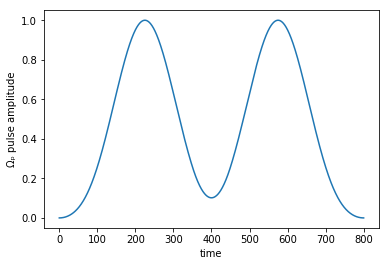

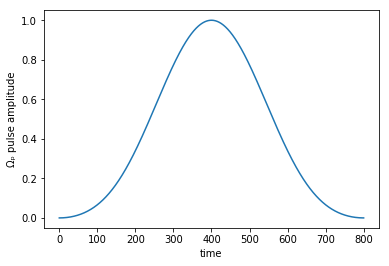

In [18]:
plot_pulse(L[1][1], tlist, 'Ωₚ')
plot_pulse(L[3][1], tlist, 'Ωₚ')

## Optimize

<div class="alert alert-block alert-danger">
    
**Here we have a problem!!!**

This does currently not work (on my machine). It does not give an error, but shuts down the kernel...

</div>
I also had trouble running notebook 04!

In [ ]:
oct_result = krotov.optimize_pulses(
    objectives, pulse_options, tlist,
    propagator=krotov.propagators.expm,
    chi_constructor=krotov.functionals.chis_re,
    info_hook=print_fidelity, iter_stop=3)

<div class="alert alert-block alert-danger">

**Warning!**

This also makes Jupyter crash!

</div>


In [ ]:
import qutip
psi = qutip.tensor(qutip.basis(2, 0), qutip.basis(2, 1))
psi.ptrace(0)